In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

$$\%CC = \dfrac{D \cdot (B \cdot Cf_{0} + Cf) \cdot G \cdot I}{5625 \cdot CR} + A + F$$\
$$L = Playerlevel - Moblevel$$\
$$F = T \cdot L$$\
$$T = \begin{cases} 
1.50\% & L > 0 \\
0.25\% & L < 0 & \mathrm{Normal} \\
0.50\% & L < 0 & \mathrm{Bam} \end{cases}$$

$A$ = Additional Crit Chance

$B$ = Glyph Value of Base Crit Factor

$D$ = Directional Modifier (1000 = Front, 1200 = Side, 1600 = Back)

$F$ = Level difference Modifier

$G$ = Glyph Value of Crit Chance Glyph (Glyphs/Passives that increase Crit Chance)

$I$ = Skill Innate Crit Modifier

$\%CC$ = Crit Chance

$CR$ = Crit Resist Factor (For current bosses the base is 210)

$Cf_{0}$ = Class Base Crit Factor

$Cf$ = Bonus Crit Factor

$L$ = Playerlevel - Moblevel

In [2]:
# skills
# [base damage, phy factor, innate, glyph, additional cc, base cf multiplier, glyph_dmg (15 focus + ww)]

skills = {
    'ht':  [4514*1.07, 1.5, 1.4, 1, 0, 2, 0.4],
    'kds': [4290*1.07, 1.5, 1, 1, 0, 2, 0.4],
    'ww':  [4868*1.07/2, 1.4, 1, 1, 0.1, 2, 0.4],
    'ohs': [2754*1.1, 1.3, 1.3, 1, 0, 0, 0.65],
    'ev':  [4043*1.07, 1.3, 1.5, 1, 0, 0, 0.4],
    'pb':  [15421, 1.75, 3, 1, 0, 0, 0.4],
    'ms':  [6443, 1.5, 1.5, 3, 0, 0, 0.65],
    'ss':  [2857, 1.2, 10, 1, 0, 0, 0.4]
}

In [3]:
# hpms from sample log

hpm_noicb = {
    'ht': 2.98,
    'kds': 0,
    'ww': 29.83,
    'ohs': 26.84,
    'ev': 10.94,
    'pb': 7.95,
    'ms': 14.91,
    'ss': 7.95
}

hpm_icb = {
    'ht': 6.79,
    'kds': 2.26,
    'ww': 31.68,
    'ohs': 49.78,
    'ev': 9.05,
    'pb': 9.05,
    'ms': 15.84,
    'ss': 9.05
}

In [4]:
def crit_chance(crit_factor, skill, is_icb):
    
    A = skills[skill][4]
    B = skills[skill][5]
    D = 1600
    G = skills[skill][3]
    I = skills[skill][2]
    CR = 232-12-25
    Cf0 = 56
    Cf = crit_factor
    L = -0
    F = 0.005*L

    if is_icb:
        G += 0.25
    
    CC = ((D * ((B * Cf0) + Cf) * G * I)/(5625*CR)) + A + F
    
    return CC

In [5]:
def skill_damage(skill, cp, phy_amp, phy_cp, glyph_dmg, is_crit: bool, is_icb=False):
    
    s_def = 40000 - 15000 - (0.04*phy_amp)
    base_damage = skills[skill][0]
    phy_factor = skills[skill][1]
    bam_crit_mult = 0.9
    
    if not is_crit: 
        cp = 1
        phy_cp = 1
        bam_crit_mult = 1
    
    if is_icb:
        glyph_dmg += 0.15
        if skill == 'ohs':
            glyph_dmg += 0.40
    
    total_mod = cp * bam_crit_mult + (phy_amp * phy_factor * phy_cp / (100000 + s_def))
    total_damage = base_damage * total_mod * (1 + glyph_dmg)
    
    return total_damage

In [6]:
def total_hpm(icb_uptime):
    
    hpm = {}
    
    for skill in hpm_noicb:
        hpm[skill] = hpm_icb[skill] * icb_uptime + hpm_noicb[skill] * (1-icb_uptime)
    
    return hpm

In [7]:
def total_damage(power, crit_factor, cp, phy_amp, phy_cp, icb_uptime, breakdown=False):
    
    result = {}
    dmg_sum = 0
    
    for skill in skills:
        s = []
        cc_noicb = min(1, crit_chance(crit_factor, skill, False))
        cc_icb = min(1, crit_chance(crit_factor, skill, True))
        glyph_dmg = skills[skill][6]
        
        dmg_noicb = (((power + 100)/(70 + 100)) * hpm_noicb[skill] *
                        (1-icb_uptime) * ((cc_noicb * skill_damage(skill, cp, phy_amp, phy_cp, glyph_dmg, True))
                        + ((1-cc_noicb) * skill_damage(skill, cp, phy_amp, phy_cp, glyph_dmg, False))))
        dmg_icb = (((power + 25 + 100)/(70 + 100)) * hpm_icb[skill] *
                        icb_uptime * ((cc_icb * skill_damage(skill, cp, phy_amp, phy_cp, glyph_dmg, True, True))
                        + ((1-cc_icb) * skill_damage(skill, cp, phy_amp, phy_cp, glyph_dmg, False, True))))

        s.extend([cc_icb*icb_uptime + cc_noicb*(1-icb_uptime), dmg_noicb, dmg_icb, dmg_noicb + dmg_icb])
        dmg_sum += dmg_noicb + dmg_icb
        result[skill] = s
    
    for skill in result:
        total_skill_dmg = result[skill][3]
        percent_dmg = 100 * total_skill_dmg/dmg_sum
        result[skill].append(percent_dmg)

    if breakdown:
        print(dmg_sum)
        return result
    else:
        return dmg_sum

In [8]:
power_0 = 359+48
cf_0 = 304+(1.2*56)+20
cp_0 = 3.44+(0.1*1.0)+(0.1*2.0)+(0.45*0.7)
phy_amp = 123280
phy_cp = 2.16


power_array_0 = np.linspace(power_0 + 150, power_0 - 49, 200)
cf_array_0 = np.linspace(cf_0 - 300, cf_0 + 98, 200)


In [9]:
r_0 = np.array([total_damage(power_array_0[i]+(.8*15)+(0.5*16)+(0.14*30)+17,
                            cf_array_0[i]+(0.5*20)+(0.14*30), cp_0, phy_amp, phy_cp, 0.35)
                            for i, j in enumerate(power_array_0)])

print(np.max(r_0))
print(np.argmax(r_0))
print(cf_array_0[np.argmax(r_0)])

18328695.218190223
62
215.2


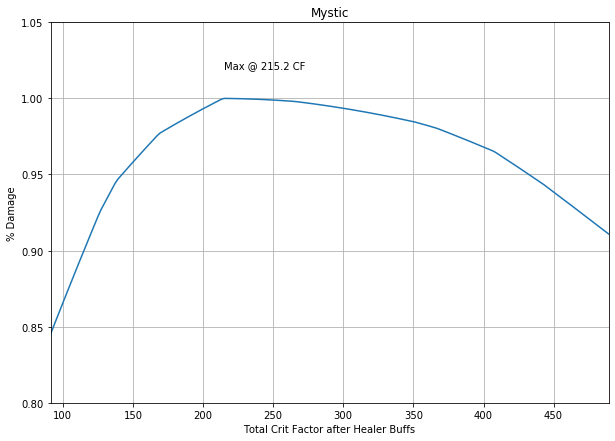

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(cf_array_0, r_0/np.max(r_0))
plt.title("Mystic")
plt.xlim(cf_array_0[0], cf_array_0[-1])
plt.ylim(0.8, 1.05)
plt.xlabel("Total Crit Factor after Healer Buffs")
plt.ylabel("% Damage")
plt.grid(True)
plt.text(cf_array_0[np.argmax(r_0)], 1.02, f"Max @ {cf_array_0[np.argmax(r_0)]} CF")
plt.show()

In [11]:
power_1 = 359+65
cf_1 = 304+20+20
cp_1 = 3.44+(0.1*1.0)+(0.1*2.0)+(0.55*0.2)
phy_amp = 123280
phy_cp = 2.16


power_array_1 = np.linspace(power_1 + 150, power_1 - 49, 200)
cf_array_1 = np.linspace(cf_1 - 300, cf_1 + 98, 200)


In [12]:
r_1 = np.array([total_damage(power_array_1[i]+(.55*15)+(0.5*16)+(0.14*30)+(0.35*50)+17,
                            cf_array_1[i]+(0.5*20)+(0.14*30)+(0.35*30), cp_1, phy_amp, phy_cp, 0.35)
                            for i, j in enumerate(power_array_1)])

print(np.max(r_1))
print(np.argmax(r_1))
print(cf_array_1[np.argmax(r_1)])

18230176.993328445
80
204.0


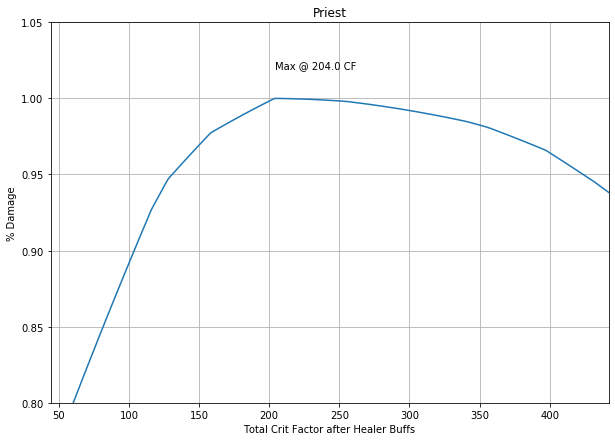

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(cf_array_1, r_1/np.max(r_1))
plt.title("Priest")
plt.xlim(cf_array_1[0], cf_array_1[-1])
plt.ylim(0.8, 1.05)
plt.xlabel("Total Crit Factor after Healer Buffs")
plt.ylabel("% Damage")
plt.grid(True)
plt.text(cf_array_1[np.argmax(r_1)], 1.02, f"Max @ {cf_array_1[np.argmax(r_1)]} CF")
plt.show()